In [1]:
import os
import cv2
import math
import torch
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings

/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_covariance_matrix(number_files, batch_size, captured_data_list):
    captured_z_outsource_data = np.zeros(((number_files-1)*batch_size, 256))

    for i in range(number_files-1):
        z_outsource_file_list = f"{captured_data_list}/z_{i+1}.pth"
        captured_z_outsource = torch.load(z_outsource_file_list).to("cpu")
        captured_z_outsource_data[i*batch_size:(i+1)*batch_size] = captured_z_outsource.detach().numpy()
    covariance_matrix_z_outsource = np.cov(captured_z_outsource_data, rowvar=False)
    return covariance_matrix_z_outsource, captured_z_outsource_data

def calculate_covariance_matrix_outsource_latent_code(number_files, batch_size, captured_data_list):

    captured_z_outsource_data = np.zeros(((number_files-1)*batch_size, 256))

    for i in range(number_files-1):
        z_outsource_file_list = f"{captured_data_list}/z_outsource_{i+1}.pth"
        captured_z_outsource = torch.load(z_outsource_file_list).to("cpu")
        captured_z_outsource_data[i*batch_size:(i+1)*batch_size] = captured_z_outsource.detach().numpy()
    covariance_matrix_z_outsource = np.cov(captured_z_outsource_data, rowvar=False)
    return covariance_matrix_z_outsource


def plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, img_save_path):
    U, s, V = np.linalg.svd(covariance_matrix_z_outsource)

    X = [i for i in range(covariance_matrix_z_outsource.shape[0])]

    # Data for plotting
    SMALL_SIZE = 20
    MEDIUM_SIZE = 22
    BIGGER_SIZE = 24

    plt.figure(figsize=(9, 6))
    plt.plot(X, s)
    plt.title('SVD decomposition of Cov(Z): (Z vector)', fontsize=SMALL_SIZE)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.savefig(f'{img_save_path}.pdf', bbox_inches="tight", transparent=True) 

# perform noise calculation on the convariance matrix
def generation_l2norm_l2cov(covariance_matrix_z_outsource):
    l2_norm_cov = np.linalg.norm(covariance_matrix_z_outsource)
    U_cov, s_cov, V_cov = np.linalg.svd(covariance_matrix_z_outsource)
    l2_norm_cov_from_s_cov = np.linalg.norm(s_cov)
    print(f"l2_norm_cov={l2_norm_cov}  l2_norm_cov_from_s_cov={l2_norm_cov_from_s_cov}")

    print("print detailed value of individual elements in convariance:")
    for ele in s_cov:
        print(ele, end=" ")
    return l2_norm_cov, U_cov, s_cov, V_cov


# calculate noise of each dimensions
def generate_noise_covariance(mutual_info_bound, s_cov):
    overall_result_cov = 0
    for ele in s_cov:
        overall_result_cov = overall_result_cov + np.sqrt(ele)
    print()
    print(f"sum of sqrt={overall_result_cov}")
    print(f"mutual information = 1 -- noise std variance={overall_result_cov/np.sqrt(2)}")
    noise_variance = np.zeros(256)
    for i in range(256):
        print(f"s_cov[i]={s_cov[i]}, overall_result_cov={overall_result_cov}, div={(2 * mutual_info_bound)}")
        noise_variance[i] =  (np.sqrt(s_cov[i]) * overall_result_cov) / (2 * mutual_info_bound)
    return noise_variance

# Original VAE model

In [3]:
"""
    Appling noise directly to the entire outsourced model to give a certained mutual information bound
    The prior successful rate is 1/67
    This script aims at calculating the posterior successful rate
"""

# l2_norm = np.linalg.norm(captured_z_outsource_data)
# U, s_original, V = np.linalg.svd(captured_z_outsource_data)
# print(s_original)
"""
    perform noise calculation on the original data
"""
# overall_result = 0
# for ele in s_original:
#     overall_result = overall_result + np.sqrt(ele)
# overall_result = overall_result / 256
# print(overall_result)
# l2_norm_svd_decomposition_original = np.linalg.norm(s_original)
# l2_norm = np.linalg.norm(captured_z_outsource_data)
# print(f"l2_norm = {l2_norm}")
# print("print detailed value of individual elements:")
# for ele in s_original:
#     print(ele, end=" ")

'\n    perform noise calculation on the original data\n'

In [4]:
threshold = 0 #4, 5]

number_files = 5566
batch_size = 8

num_element_mean = 256
mutual_info_bound = 1
num_samples = 1

captured_data_list = f"/home/jianming/work/Privatar_prj/profiled_latent_code/original_model"
noise_covariance_path = f"/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_{threshold}_mutual_bound_{mutual_info_bound}"

l2_norm_cov=90.01610095779368  l2_norm_cov_from_s_cov=90.01610095779361
print detailed value of individual elements in convariance:
47.78184262871633 42.54976842690697 37.48630687334613 26.81936970055225 23.816130941461264 17.72968626832257 12.303727227411377 11.02972508351893 10.03795954512834 9.083945061984522 8.597538053165296 7.47576872856127 6.5604329891750455 5.7706151797950955 5.565643767795566 5.281540825002937 4.970296650680008 3.66663421973178 3.4408062245282207 3.1405700367264973 2.607845141442679 2.3993553395257234 2.3735864502344257 2.342078794604674 1.9150992017306654 1.8016994227600478 1.782021806793627 1.6223011534451879 1.5186149109311051 1.3563169213459965 1.328614848008131 1.2758747862276887 1.2210728618190299 1.1762705856080231 1.1653017583707292 1.1446136659047343 1.104156526399322 1.0971034775635697 1.0850522029653933 1.0770145163066063 1.0729462669416643 1.0615133879967205 1.060952415718621 1.060555308456928 1.0569653648672699 1.0546804367457598 1.050896081591838

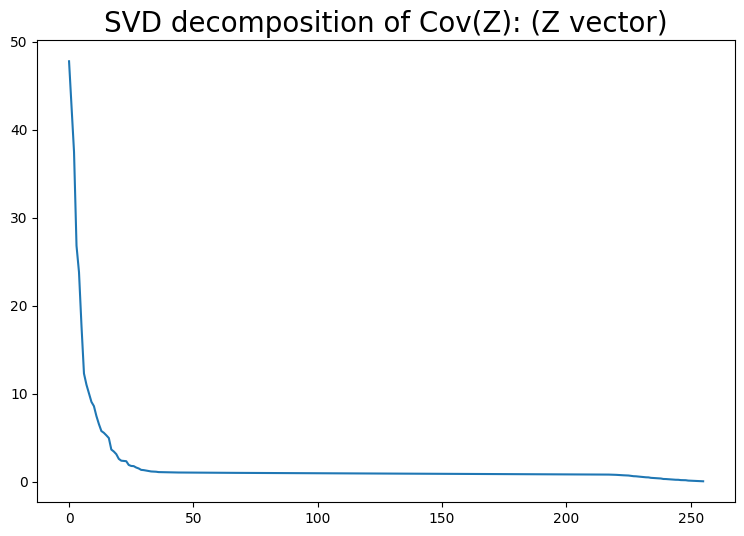

In [5]:
covariance_matrix_z_outsource, captured_z_outsource_data = calculate_covariance_matrix(number_files, batch_size, captured_data_list)

plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, noise_covariance_path)

l2_norm_cov, U_cov, s_cov, V_cov = generation_l2norm_l2cov(covariance_matrix_z_outsource)

noise_variance = generate_noise_covariance(mutual_info_bound, s_cov)

mean = np.zeros(num_element_mean)
noise_variance_eye = np.eye(256)
for i in range(256):
    noise_variance_eye[i,i] = noise_variance[i]
variance_matrix = (U_cov@noise_variance_eye@V_cov)
variance_matrix_tensor = torch.tensor(variance_matrix)
torch.save(variance_matrix_tensor, f"{noise_covariance_path}.pth")
noise_samples = np.random.multivariate_normal(mean, variance_matrix, num_samples)

print(f"noise l2 norm = {l2_norm_cov}")
print(f"L2 norm of generated noise:{np.linalg.norm(noise_samples)}")
print("sampled noise:")
for i in range(256):
    print(noise_samples[0,i], end=" ")

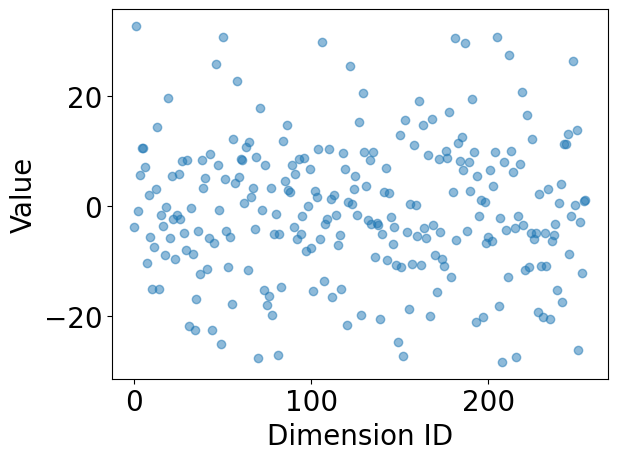

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = [i for i  in range(num_element_mean)]
plt.scatter(x, noise_samples, alpha=0.5)
plt.xlabel('Dimension ID')
plt.ylabel('Value')
plt.show()

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([14.87980426, 14.89119546, 14.90258666, ..., 37.63942267,
        37.65081387, 37.66220507]),
 <BarContainer object of 2000 artists>)

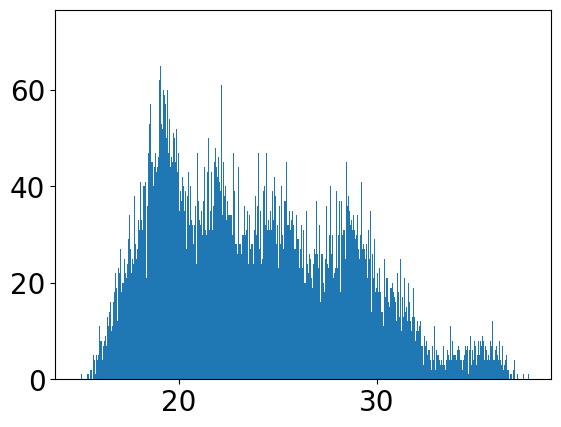

In [7]:
all_l2_norm_list = np.zeros(captured_z_outsource_data.shape[0])
for i in range(captured_z_outsource_data.shape[0]):
    all_l2_norm_list[i] = np.linalg.norm(captured_z_outsource_data[i,:])
plt.hist(all_l2_norm_list, bins=2000)

In [23]:
print(np.linalg.norm(captured_z_outsource_data))
print(np.linalg.norm(captured_z_outsource_data[0,:]))

5142.855696140467
26.322513627910443


# Horiziontal Partition Noise
### -- Threshold = 3

In [9]:
threshold = 3
# threshold_list = [0.4, 0.8, 1, 1.6, 2.4, 3, 4, 5]

number_files = 2238
batch_size = 24

num_element_mean = 256
mutual_info_bound = 1
num_samples = 1

captured_data_list = f"/home/jianming/work/Privatar_prj/testing_results/horizontal_partition_{threshold}_latent_code"
noise_covariance_path = f"/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_{threshold}_mutual_bound_{mutual_info_bound}"

l2_norm_cov=18.212734535248067  l2_norm_cov_from_s_cov=18.212734535248067
print detailed value of individual elements in convariance:
4.444451241032361 2.4306963068988368 2.1354244141381047 1.9219840375079809 1.8033511701254792 1.693069211789795 1.6553229099455602 1.6325418607748257 1.5899778571831173 1.5534375697206042 1.5335350959569876 1.5155866688605537 1.4862583536262788 1.4693427057696216 1.4546815826191815 1.445608578695181 1.41048539042176 1.3988129420272395 1.3826957077382391 1.3777356019652927 1.3736980516732846 1.3611592013147926 1.3520714007380628 1.3442030761711445 1.3395924272166593 1.3318586531784213 1.3267052714245589 1.3230130695642983 1.3173903292345273 1.3113194306265046 1.3041183519773194 1.3020533656938609 1.2875265607862063 1.2862270034289056 1.2803085082940682 1.2778506188123568 1.2731463938428849 1.271405381498229 1.2670809620412737 1.2598542722204564 1.2564229611304651 1.2502304556437567 1.2490412682108716 1.246475657946379 1.241561414556824 1.2388566569519914 

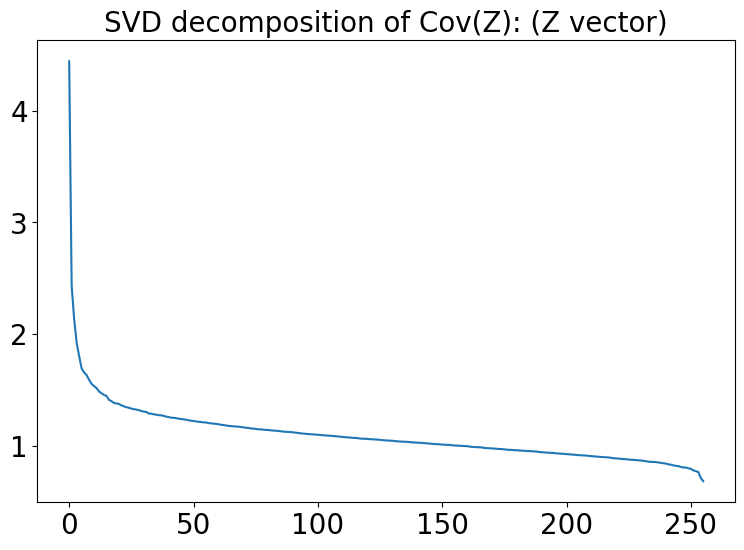

In [10]:
covariance_matrix_z_outsource = calculate_covariance_matrix_outsource_latent_code(number_files, batch_size, captured_data_list)
plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, noise_covariance_path)

l2_norm_cov, U_cov, s_cov, V_cov = generation_l2norm_l2cov(covariance_matrix_z_outsource)
print(f"l2 norm latent code covariance = {l2_norm_cov}")

noise_variance = generate_noise_covariance(mutual_info_bound, s_cov)

mean = np.zeros(num_element_mean)
noise_variance_eye = np.eye(256)
for i in range(256):
    noise_variance_eye[i,i] = noise_variance[i]
variance_matrix = (U_cov@noise_variance_eye@V_cov)
variance_matrix_tensor = torch.tensor(variance_matrix)
torch.save(variance_matrix_tensor, f"{noise_covariance_path}.pth")
samples = np.random.multivariate_normal(mean, variance_matrix, num_samples)

print(f"L2 norm of generated noise:{np.linalg.norm(samples)}")
print("sampled noise:")
for i in range(256):
    print(samples[0,i], end=" ")

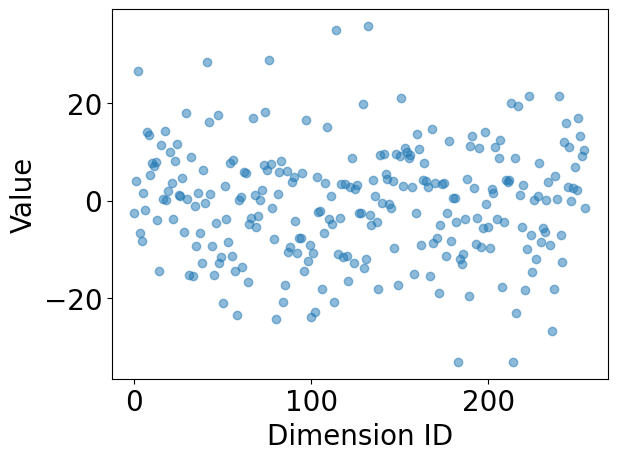

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = [i for i  in range(num_element_mean)]
plt.scatter(x, samples, alpha=0.5)
plt.xlabel('Dimension ID')
plt.ylabel('Value')
plt.show()

# Horiziontal Partition Noise
### -- Threshold = 4

In [12]:
threshold = 4  #4, 5]
# threshold_list = [0.4, 0.8, 1, 1.6, 2.4, 3, 4, 5]

number_files = 9073
batch_size = 8

num_element_mean = 256
mutual_info_bound = 1
num_samples = 1

captured_data_list = f"/home/jianming/work/Privatar_prj/testing_results/horizontal_partition_{threshold}_latent_code"
noise_covariance_path = f"/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_{threshold}_mutual_bound_{mutual_info_bound}"

l2_norm_cov=17.675987917162253  l2_norm_cov_from_s_cov=17.67598791716225
print detailed value of individual elements in convariance:
3.667683665536124 1.9132879174488948 1.806300223140759 1.6688819213036763 1.6571117497154915 1.6026988184382587 1.5761720465724638 1.498016528477491 1.4798729183783523 1.4338028477459501 1.4173546437426794 1.3816033525530955 1.3708209650430698 1.3600038752623766 1.3505803050830278 1.3418993073136234 1.315020609251616 1.313621917821104 1.3113683341128217 1.3009973383275253 1.2947129430548805 1.2907562582564682 1.274276612955928 1.2665356607434894 1.2635466425260786 1.2526698556475724 1.2503048552902487 1.242118543710146 1.2404430156193178 1.2368171397664116 1.2358406382446772 1.2311764196715882 1.227279958865448 1.223591245204973 1.2170695079338572 1.2139353979606597 1.212708479738252 1.2079746543199472 1.204163251488573 1.1984024239371271 1.1964703792645317 1.1927696781782087 1.190834284155057 1.19022210601586 1.1870146953655074 1.1864030554433005 1.18088

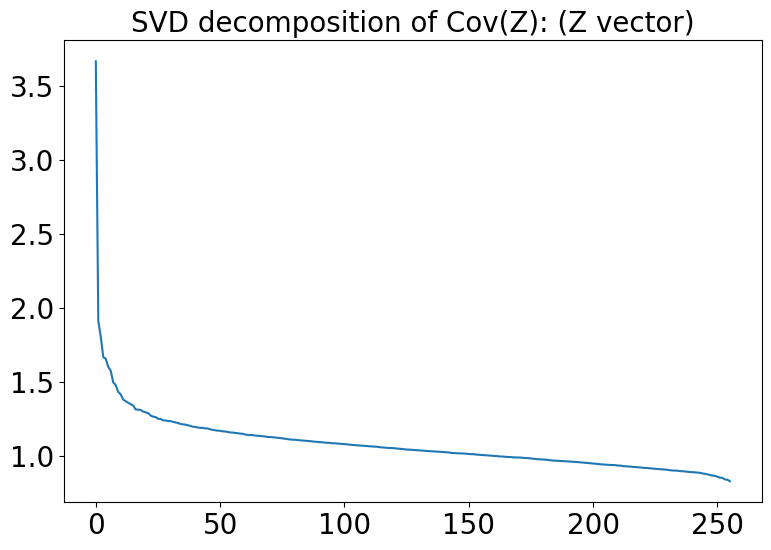

In [13]:
covariance_matrix_z_outsource = calculate_covariance_matrix_outsource_latent_code(number_files, batch_size, captured_data_list)
plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, noise_covariance_path)

l2_norm_cov, U_cov, s_cov, V_cov = generation_l2norm_l2cov(covariance_matrix_z_outsource)
print(f"l2 norm latent code covariance = {l2_norm_cov}")

noise_variance = generate_noise_covariance(mutual_info_bound, s_cov)

mean = np.zeros(num_element_mean)
noise_variance_eye = np.eye(256)
for i in range(256):
    noise_variance_eye[i,i] = noise_variance[i]
variance_matrix = (U_cov@noise_variance_eye@V_cov)
variance_matrix_tensor = torch.tensor(variance_matrix)
torch.save(variance_matrix_tensor, f"{noise_covariance_path}.pth")
samples = np.random.multivariate_normal(mean, variance_matrix, num_samples)

print(f"L2 norm of generated noise:{np.linalg.norm(samples)}")
print("sampled noise:")
for i in range(256):
    print(samples[0,i], end=" ")

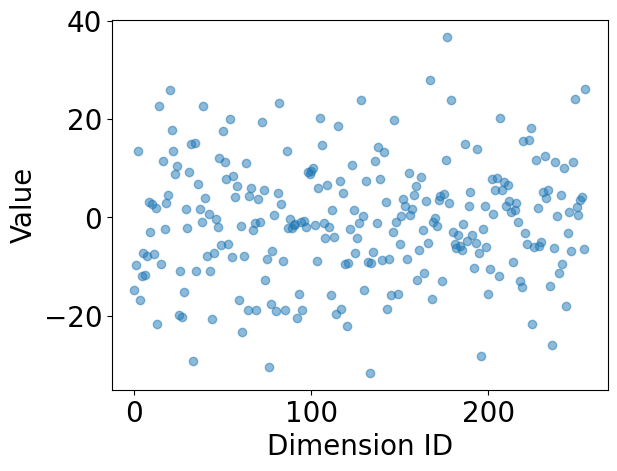

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = [i for i  in range(num_element_mean)]
plt.scatter(x, samples, alpha=0.5)
plt.xlabel('Dimension ID')
plt.ylabel('Value')
plt.show()

# Horiziontal Partition Noise
### -- Threshold = 5

In [15]:
threshold = 5
# threshold_list = [0.4, 0.8, 1, 1.6, 2.4, 3, 4, 5]

number_files = 9073
batch_size = 8

num_element_mean = 256
mutual_info_bound = 1
num_samples = 1

captured_data_list = f"/home/jianming/work/Privatar_prj/testing_results/horizontal_partition_{threshold}_latent_code"
noise_covariance_path = f"/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_{threshold}_mutual_bound_{mutual_info_bound}"

l2_norm_cov=20.154326893868912  l2_norm_cov_from_s_cov=20.154326893868912
print detailed value of individual elements in convariance:
5.437932628152889 3.4862963235505338 3.1044904260043302 2.6350373385024417 2.5272207206388697 2.4267155377006557 2.3282134015658893 2.2169795804693573 2.1139766163619345 1.9687920053128665 1.9500117933129377 1.8788127301088622 1.780768873686757 1.7715678159715598 1.7557326240814195 1.735489590775505 1.6929637158594115 1.6559833852566948 1.6418368502355791 1.635330003820323 1.6026627677170888 1.5827042625301357 1.574254957698889 1.5579918436462474 1.5335403212022538 1.525077154040774 1.5058536897955348 1.4964130153743638 1.4841652924622373 1.4809796744776993 1.472820077838698 1.4650802635694655 1.4507941227984167 1.445766817511132 1.4289283649609827 1.424622676018634 1.4108529948589301 1.4041938708556845 1.401407904222588 1.3921729158131533 1.3860237089258074 1.383988443016934 1.3790516203024055 1.3700167491746624 1.3609354640632736 1.3551241111225947 1.3

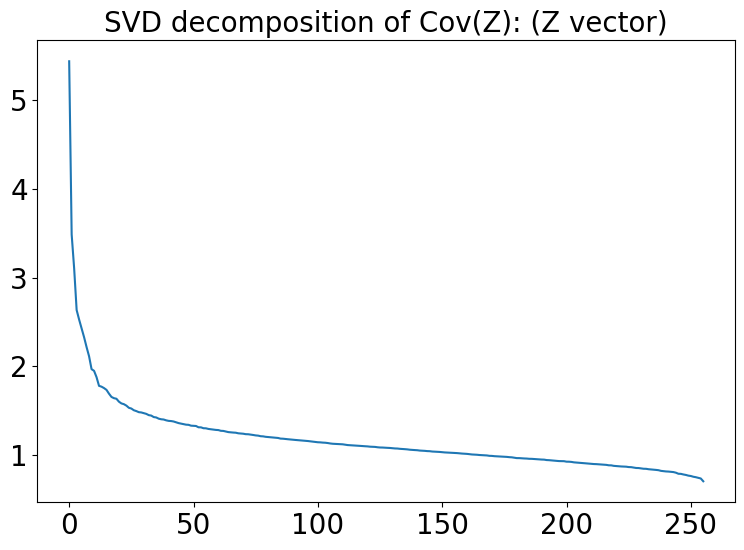

In [16]:
covariance_matrix_z_outsource = calculate_covariance_matrix_outsource_latent_code(number_files, batch_size, captured_data_list)
plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, noise_covariance_path)

l2_norm_cov, U_cov, s_cov, V_cov = generation_l2norm_l2cov(covariance_matrix_z_outsource)
print(f"l2 norm latent code covariance = {l2_norm_cov}")

noise_variance = generate_noise_covariance(mutual_info_bound, s_cov)

mean = np.zeros(num_element_mean)
noise_variance_eye = np.eye(256)
for i in range(256):
    noise_variance_eye[i,i] = noise_variance[i]
variance_matrix = (U_cov@noise_variance_eye@V_cov)
variance_matrix_tensor = torch.tensor(variance_matrix)
torch.save(variance_matrix_tensor, f"{noise_covariance_path}.pth")
samples = np.random.multivariate_normal(mean, variance_matrix, num_samples)

print(f"L2 norm of generated noise:{np.linalg.norm(samples)}")
print("sampled noise:")
for i in range(256):
    print(samples[0,i], end=" ")

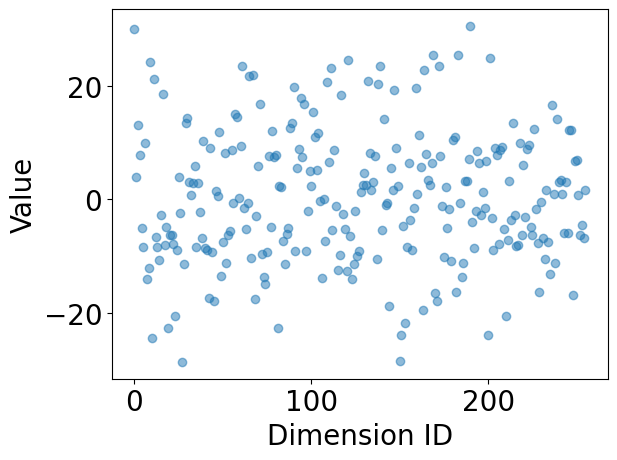

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = [i for i  in range(num_element_mean)]
plt.scatter(x, samples, alpha=0.5)
plt.xlabel('Dimension ID')
plt.ylabel('Value')
plt.show()

# Isotropic Noise Perturbation
### Threshold = 3

In [10]:
import math
import torch 
import numpy as np 
import matplotlib.pyplot as plt

In [11]:
def calculate_covariance_matrix(number_files, batch_size, captured_data_list):
    captured_z_outsource_data = np.zeros(((number_files-1)*batch_size, 256))

    for i in range(number_files-1):
        z_outsource_file_list = f"{captured_data_list}/z_{i+1}.pth"
        captured_z_outsource = torch.load(z_outsource_file_list).to("cpu")
        captured_z_outsource_data[i*batch_size:(i+1)*batch_size] = captured_z_outsource.detach().numpy()
    covariance_matrix_z_outsource = np.cov(captured_z_outsource_data, rowvar=False)
    return covariance_matrix_z_outsource, captured_z_outsource_data

def calculate_covariance_matrix_outsource_latent_code(number_files, batch_size, captured_data_list):

    captured_z_outsource_data = np.zeros(((number_files-1)*batch_size, 256))

    for i in range(number_files-1):
        z_outsource_file_list = f"{captured_data_list}/z_outsource_{i+1}.pth"
        captured_z_outsource = torch.load(z_outsource_file_list).to("cpu")
        captured_z_outsource_data[i*batch_size:(i+1)*batch_size] = captured_z_outsource.detach().numpy()
    covariance_matrix_z_outsource = np.cov(captured_z_outsource_data, rowvar=False)
    return covariance_matrix_z_outsource


def plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, img_save_path):
    U, s, V = np.linalg.svd(covariance_matrix_z_outsource)

    X = [i for i in range(covariance_matrix_z_outsource.shape[0])]

    # Data for plotting
    SMALL_SIZE = 20
    MEDIUM_SIZE = 22
    BIGGER_SIZE = 24

    plt.figure(figsize=(9, 6))
    plt.plot(X, s)
    plt.title('SVD decomposition of Cov(Z): (Z vector)', fontsize=SMALL_SIZE)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.savefig(f'{img_save_path}.pdf', bbox_inches="tight", transparent=True) 

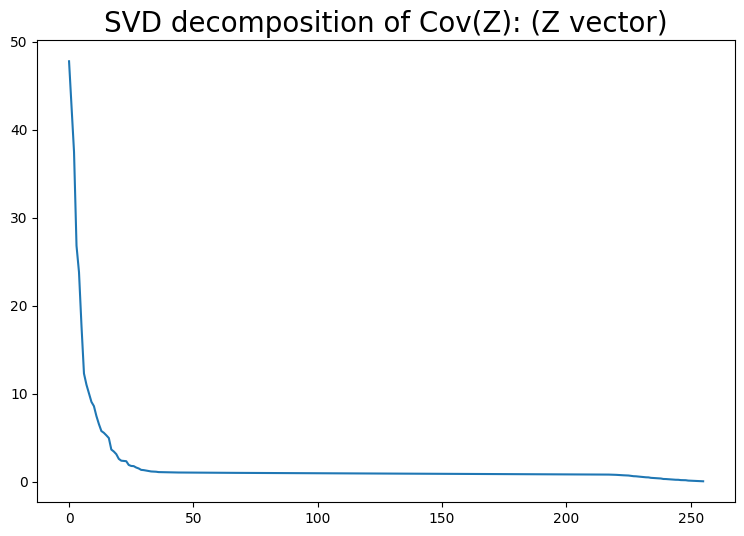

In [12]:
threshold = 0 #4, 5]

number_files = 5566
batch_size = 8

num_element_mean = 256
mutual_info_bound = 1
num_samples = 1

captured_data_list = f"/home/jianming/work/Privatar_prj/profiled_latent_code/original_model"
noise_covariance_path = f"/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_{threshold}_mutual_bound_{mutual_info_bound}"

covariance_matrix_z_outsource, captured_z_outsource_data = calculate_covariance_matrix(number_files, batch_size, captured_data_list)

plot_eigenvalue_covariance_matrix(covariance_matrix_z_outsource, noise_covariance_path)

In [37]:
print(np.linalg.det(covariance_matrix_z_outsource))

unit_diagonal = np.diag(np.full(covariance_matrix_z_outsource.shape[0],1))
for b in range(0, 100):
    var = (b+1)*0.01 + 246.4
    result_matrix = unit_diagonal + covariance_matrix_z_outsource / var
    if abs(np.linalg.det(result_matrix) - math.e**2) < 1e-2:
        print(f"[Done]noise var={var}, diff = {abs(np.linalg.det(result_matrix) - math.e**2)}, det ={np.linalg.det(result_matrix)}")
    else:
        print(f"noise var={var}, np.linalg.det(result_matrix)={np.linalg.det(result_matrix)} math.e**2={math.e**2}, diff = {abs(np.linalg.det(result_matrix) - math.e**2)}")


8.77531781288055
noise var=246.41, np.linalg.det(result_matrix)=7.401426143371748 math.e**2=7.3890560989306495, diff = 0.012370044441098571
noise var=246.42000000000002, np.linalg.det(result_matrix)=7.400841773472734 math.e**2=7.3890560989306495, diff = 0.011785674542084124
noise var=246.43, np.linalg.det(result_matrix)=7.40025749587801 math.e**2=7.3890560989306495, diff = 0.01120139694736011
noise var=246.44, np.linalg.det(result_matrix)=7.399673310567324 math.e**2=7.3890560989306495, diff = 0.010617211636674284
noise var=246.45000000000002, np.linalg.det(result_matrix)=7.399089217520843 math.e**2=7.3890560989306495, diff = 0.010033118590193624
[Done]noise var=246.46, diff = 0.009449117787806216, det =7.398505216718456
[Done]noise var=246.47, diff = 0.008865209209413472, det =7.397921308140063
[Done]noise var=246.48000000000002, diff = 0.008281392835007395, det =7.397337491765657
[Done]noise var=246.49, diff = 0.0076976686446057485, det =7.396753767575255
[Done]noise var=246.5, diff =

In [43]:
# generate isotropic noise covariance.

noise_covaraince = np.eye(256) *246.46
noise_covaraince_tensor = torch.from_numpy(noise_covaraince)
torch.save(noise_covaraince_tensor, "/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/isotropic_noise_246.46_mutual_information_1.pth")

In [44]:
mean = np.zeros(256)
samples = torch.from_numpy(np.random.multivariate_normal(mean, noise_covaraince_tensor, 1))